In [1]:
'''
Build a suggorate model for the data
there is a DNN models that want to build
if there are 3 dataset, then there are 3 models after training
Example Code : https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=3
'''

'\nBuild a suggorate model for the data\nthere is a DNN models that want to build\nif there are 3 dataset, then there are 3 models after training\nExample Code : https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=3\n'

In [2]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm  # For nice progress bar!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

def draw_plot(accuracy_stats, loss_stats):

    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

    # modify column names
    train_val_acc_df.columns = ['epochs', 'status', 'accuracy']
    train_val_loss_df.columns = ['epochs', 'status', 'loss']
    
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    
    # change the limits of y-axis
    axes[0].set_ylim(0, 1) 
    axes[1].set_ylim(0, 1)
    
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="accuracy", hue="status",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="loss", hue="status", ax=axes[1]).set_title('Train-Val Loss/Epoch')


In [4]:
from sklearn.metrics import confusion_matrix

# draw confusion matrix
def draw_confusion_matrix(y_test, y_pred, model, model_name, dataset_resource):
    cm = confusion_matrix(y_test, y_pred)
    total = np.sum(cm)
    confusion_percentage = (cm  / total) * 100

    strings = np.asarray([['%', '%'],
                        ['%', '%']])
    labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 10})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix of {model_name} Surrogate Model', fontsize=15)
    # add accuracy
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.text(0.5, 2.5, f'Dataset from: {dataset_resource}', dict(size=12))
    
    plt.show()

In [5]:
def Preprocess_GAN(train, label):
    # min max standardization
    # 創建一個MinMaxScaler對象
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler = RobustScaler()
    # 選擇所有數值型列，並移除"BwdPSHFlags"
    numeric_columns = list(train.select_dtypes(include=['int', "float"]).columns)
    numeric_columns.remove("BwdPSHFlags")
    numeric_columns.remove(label)

    # 對每一個數值型列進行縮放
    for c in numeric_columns:
        train[c] = scaler.fit_transform(train[[c]])
        # print("scalar max: ", scaler.data_max_)
        # print("scalar min: ", scaler.data_min_)

    # get the true label of the train set
    true_label = train[label]

    # del train[label]
    return_train = train.drop(label, axis=1)

    return return_train, true_label

In [6]:
train_lr_predicted = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv')
test_lr_predicted = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv')
# change the last column name to "Label"
last_column = train_lr_predicted.columns[-1]
train_lr_predicted.rename(columns={last_column: "Label"}, inplace=True)

train_dt_predicted = pd.read_csv('../surrogate_model/data_for_training/0322/df_dt_predicted_0322.csv')
test_dt_predicted = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv')
last_column = train_dt_predicted.columns[-1]
train_dt_predicted.rename(columns={last_column: "Label"}, inplace=True)

train_xgb_predicted = pd.read_csv('../surrogate_model/data_for_training/0322/df_xgb_predicted_0322.csv')
test_xgb_predicted = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv')
last_column = train_xgb_predicted.columns[-1]
train_xgb_predicted.rename(columns={last_column: "Label"}, inplace=True)

train_dnn_predicted = pd.read_csv('../surrogate_model/data_for_training/0322/df_dnn_predicted_0322.csv')
test_dnn_predicted = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv')
last_column = train_dnn_predicted.columns[-1]
train_dnn_predicted.rename(columns={last_column: "Label"}, inplace=True)


# train test split
X = train_lr_predicted.drop("Label", axis=1)
y = train_lr_predicted["Label"]
X_train_lr_predicted, X_val_lr_predicted, y_train_lr_predicted, y_val_lr_predicted = train_test_split(X, y, test_size=0.1, random_state=42)
val_lr_predicted = pd.concat([X_val_lr_predicted, y_val_lr_predicted], axis=1)
train_lr_predicted = pd.concat([X_train_lr_predicted, y_train_lr_predicted], axis=1)

X = train_dt_predicted.drop("Label", axis=1)
y = train_dt_predicted["Label"]
X_train_dt_predicted, X_val_dt_predicted, y_train_dt_predicted, y_val_dt_predicted = train_test_split(X, y, test_size=0.1, random_state=42)
val_dt_predicted = pd.concat([X_val_dt_predicted, y_val_dt_predicted], axis=1)
train_dt_predicted = pd.concat([X_train_dt_predicted, y_train_dt_predicted], axis=1)

X = train_xgb_predicted.drop("Label", axis=1)
y = train_xgb_predicted["Label"]
X_train_xgb_predicted, X_val_xgb_predicted, y_train_xgb_predicted, y_val_xgb_predicted = train_test_split(X, y, test_size=0.1, random_state=42)
val_xgb_predicted = pd.concat([X_val_xgb_predicted, y_val_xgb_predicted], axis=1)
train_xgb_predicted = pd.concat([X_train_xgb_predicted, y_train_xgb_predicted], axis=1)

X = train_dnn_predicted.drop("Label", axis=1)
y = train_dnn_predicted["Label"]
X_train_dnn_predicted, X_val_dnn_predicted, y_train_dnn_predicted, y_val_dnn_predicted = train_test_split(X, y, test_size=0.1, random_state=42)
val_dnn_predicted = pd.concat([X_val_dnn_predicted, y_val_dnn_predicted], axis=1)
train_dnn_predicted = pd.concat([X_train_dnn_predicted, y_train_dnn_predicted], axis=1)


In [7]:
test_lr_predicted['Label'].value_counts()

Label
0    12571
1     4701
Name: count, dtype: int64

In [8]:
X_train_lr_predicted, y_train_lr_predicted  = Preprocess_GAN(train_lr_predicted, "Label")
X_val_lr_predicted, y_val_lr_predicted = Preprocess_GAN(val_lr_predicted, "Label")
X_test_lr_predicted, y_test_lr_predicted = Preprocess_GAN(test_lr_predicted, "Label")

X_train_dt_predicted, y_train_dt_predicted = Preprocess_GAN(train_dt_predicted, "Label")
X_val_dt_predicted, y_val_dt_predicted = Preprocess_GAN(val_dt_predicted, "Label")
X_test_dt_predicted, y_test_dt_predicted = Preprocess_GAN(test_dt_predicted, "Label")

X_train_xgb_predicted, y_train_xgb_predicted = Preprocess_GAN(train_xgb_predicted, "Label")
X_val_xgb_predicted, y_val_xgb_predicted = Preprocess_GAN(val_xgb_predicted, "Label")
X_test_xgb_predicted, y_test_xgb_predicted = Preprocess_GAN(test_xgb_predicted, "Label")

X_train_dnn_predicted, y_train_dnn_predicted = Preprocess_GAN(train_dnn_predicted, "Label")
X_val_dnn_predicted, y_val_dnn_predicted = Preprocess_GAN(val_dnn_predicted, "Label")
X_test_dnn_predicted, y_test_dnn_predicted = Preprocess_GAN(test_dnn_predicted, "Label")

In [9]:
# Hyperparameters
input_size = len(X_train_xgb_predicted.columns) # 42
num_classes = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [10]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



In [11]:
# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works and is a general approach.
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(DNN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        # self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.act3 = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """

        #x = F.relu(self.fc1(x))
        x = self.fc1(x)
        # x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # x = self.batchnorm3(x)
        x = self.act3(x)
        return x

In [12]:
# train model for one epoch

def train_for_one_epoch(model, train_loader, val_loader, criterion, optimizer, num_epochs):

     # train model
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        #data = data.reshape(data.shape[0], -1)

        # Forward
        y_train_pred = model(data)
        
        # train_loss, train_acc per batch
        train_loss = criterion(y_train_pred, targets) 
        train_acc  = (y_train_pred.argmax(1) == targets).float().sum() / len(targets)
        
        # Backward
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        train_epoch_loss += train_loss.item()   
        train_epoch_acc += train_acc.item()
    return train_epoch_loss, train_epoch_acc

In [13]:
# test the model

def test_model(loader, model):
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            #print(_, y_pred_tags.cpu().numpy())
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_pred_list

In [14]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

### Train for Logistic Regression Predicted Data

In [15]:

train_dataset = ClassifierDataset(torch.tensor(np.array(X_train_lr_predicted)).float(), torch.tensor(np.array(y_train_lr_predicted)).long())
val_dataset = ClassifierDataset(torch.tensor(np.array(X_val_lr_predicted)).float(), torch.tensor(np.array(y_val_lr_predicted)).long())
test_dataset = ClassifierDataset(torch.tensor(np.array(X_test_lr_predicted)).float(), torch.tensor(np.array(y_test_lr_predicted)).long())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [16]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from datetime import datetime


# Initialize network
model = DNN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# accuracy, loss status for each epoch
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train Network
for epoch in range(num_epochs):
    
    # train model
    train_epoch_loss, train_epoch_acc = train_for_one_epoch(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        
    # validate model
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            val_loss = criterion(voutputs, vlabels)
            val_acc = (voutputs.argmax(1) == vlabels).float().sum() / len(vlabels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    avg_vloss = val_epoch_loss/len(val_loader)


    # save the accuracy and loss for each epoch   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../surrogate_model/surrogate_DNN_model/surrogateDNN_model_fromLR_{}_{}'.format(timestamp, epoch) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_epoch_acc/len(val_loader):.4f}')

        

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model

    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
           # x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")


Begin training.


 50%|█████     | 121/242 [00:00<00:00, 410.98it/s]

100%|██████████| 242/242 [00:00<00:00, 430.89it/s]


Epoch 1: | Train Loss: 0.48034 | Val Loss: 0.40368 | Train Acc: 0.8647| Val Acc: 0.9196


100%|██████████| 242/242 [00:00<00:00, 527.11it/s]


Epoch 2: | Train Loss: 0.41479 | Val Loss: 0.39585 | Train Acc: 0.9031| Val Acc: 0.9201


100%|██████████| 242/242 [00:00<00:00, 504.93it/s]


Epoch 3: | Train Loss: 0.41023 | Val Loss: 0.39436 | Train Acc: 0.9046| Val Acc: 0.9201


100%|██████████| 242/242 [00:00<00:00, 538.82it/s]


Epoch 4: | Train Loss: 0.40990 | Val Loss: 0.39211 | Train Acc: 0.9041| Val Acc: 0.9213


100%|██████████| 242/242 [00:00<00:00, 537.64it/s]


Epoch 5: | Train Loss: 0.40941 | Val Loss: 0.39227 | Train Acc: 0.9042| Val Acc: 0.9219


100%|██████████| 242/242 [00:00<00:00, 460.55it/s]


Epoch 6: | Train Loss: 0.40745 | Val Loss: 0.39215 | Train Acc: 0.9057| Val Acc: 0.9219


100%|██████████| 242/242 [00:00<00:00, 514.69it/s]


Epoch 7: | Train Loss: 0.40733 | Val Loss: 0.39359 | Train Acc: 0.9066| Val Acc: 0.9196


100%|██████████| 242/242 [00:00<00:00, 530.82it/s]


Epoch 8: | Train Loss: 0.40641 | Val Loss: 0.39079 | Train Acc: 0.9070| Val Acc: 0.9230


100%|██████████| 242/242 [00:00<00:00, 542.37it/s]


Epoch 9: | Train Loss: 0.40532 | Val Loss: 0.39085 | Train Acc: 0.9083| Val Acc: 0.9225


100%|██████████| 242/242 [00:00<00:00, 541.97it/s]


Epoch 10: | Train Loss: 0.40484 | Val Loss: 0.39053 | Train Acc: 0.9087| Val Acc: 0.9230


100%|██████████| 242/242 [00:00<00:00, 531.75it/s]


Epoch 11: | Train Loss: 0.40514 | Val Loss: 0.38969 | Train Acc: 0.9081| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 401.23it/s]


Epoch 12: | Train Loss: 0.40527 | Val Loss: 0.39019 | Train Acc: 0.9083| Val Acc: 0.9230


100%|██████████| 242/242 [00:00<00:00, 515.88it/s]


Epoch 13: | Train Loss: 0.40500 | Val Loss: 0.38994 | Train Acc: 0.9083| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 556.20it/s]


Epoch 14: | Train Loss: 0.40527 | Val Loss: 0.39071 | Train Acc: 0.9078| Val Acc: 0.9225


100%|██████████| 242/242 [00:00<00:00, 532.92it/s]


Epoch 15: | Train Loss: 0.40388 | Val Loss: 0.39014 | Train Acc: 0.9091| Val Acc: 0.9230


100%|██████████| 242/242 [00:00<00:00, 515.87it/s]


Epoch 16: | Train Loss: 0.40412 | Val Loss: 0.38984 | Train Acc: 0.9091| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 521.43it/s]


Epoch 17: | Train Loss: 0.40340 | Val Loss: 0.38972 | Train Acc: 0.9101| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 553.54it/s]


Epoch 18: | Train Loss: 0.40359 | Val Loss: 0.38945 | Train Acc: 0.9098| Val Acc: 0.9242


100%|██████████| 242/242 [00:00<00:00, 535.28it/s]


Epoch 19: | Train Loss: 0.40301 | Val Loss: 0.38983 | Train Acc: 0.9101| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 535.28it/s]


Epoch 20: | Train Loss: 0.40311 | Val Loss: 0.38982 | Train Acc: 0.9104| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 560.06it/s]


Epoch 21: | Train Loss: 0.40255 | Val Loss: 0.38953 | Train Acc: 0.9108| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 553.65it/s]


Epoch 22: | Train Loss: 0.40309 | Val Loss: 0.38919 | Train Acc: 0.9103| Val Acc: 0.9242


100%|██████████| 242/242 [00:00<00:00, 432.05it/s]


Epoch 23: | Train Loss: 0.40350 | Val Loss: 0.39855 | Train Acc: 0.9081| Val Acc: 0.9149


100%|██████████| 242/242 [00:00<00:00, 552.39it/s]


Epoch 24: | Train Loss: 0.40465 | Val Loss: 0.39836 | Train Acc: 0.9075| Val Acc: 0.9149


100%|██████████| 242/242 [00:00<00:00, 563.98it/s]


Epoch 25: | Train Loss: 0.40398 | Val Loss: 0.39806 | Train Acc: 0.9083| Val Acc: 0.9149


100%|██████████| 242/242 [00:00<00:00, 557.48it/s]


Epoch 26: | Train Loss: 0.40357 | Val Loss: 0.39786 | Train Acc: 0.9086| Val Acc: 0.9155


100%|██████████| 242/242 [00:00<00:00, 573.33it/s]


Epoch 27: | Train Loss: 0.40137 | Val Loss: 0.39783 | Train Acc: 0.9119| Val Acc: 0.9155


100%|██████████| 242/242 [00:00<00:00, 552.39it/s]


Epoch 28: | Train Loss: 0.40032 | Val Loss: 0.38740 | Train Acc: 0.9117| Val Acc: 0.9271


100%|██████████| 242/242 [00:00<00:00, 553.65it/s]


Epoch 29: | Train Loss: 0.40101 | Val Loss: 0.38764 | Train Acc: 0.9110| Val Acc: 0.9259


100%|██████████| 242/242 [00:00<00:00, 547.39it/s]


Epoch 30: | Train Loss: 0.39831 | Val Loss: 0.38785 | Train Acc: 0.9128| Val Acc: 0.9253


100%|██████████| 242/242 [00:00<00:00, 557.48it/s]


Epoch 31: | Train Loss: 0.40017 | Val Loss: 0.38879 | Train Acc: 0.9120| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 546.15it/s]


Epoch 32: | Train Loss: 0.39971 | Val Loss: 0.38834 | Train Acc: 0.9129| Val Acc: 0.9236


100%|██████████| 242/242 [00:00<00:00, 543.70it/s]


Epoch 33: | Train Loss: 0.40009 | Val Loss: 0.38830 | Train Acc: 0.9129| Val Acc: 0.9242


100%|██████████| 242/242 [00:00<00:00, 565.29it/s]


Epoch 34: | Train Loss: 0.39826 | Val Loss: 0.38587 | Train Acc: 0.9139| Val Acc: 0.9271


100%|██████████| 242/242 [00:00<00:00, 565.29it/s]


Epoch 35: | Train Loss: 0.39873 | Val Loss: 0.38646 | Train Acc: 0.9139| Val Acc: 0.9265


100%|██████████| 242/242 [00:00<00:00, 542.48it/s]


Epoch 36: | Train Loss: 0.39720 | Val Loss: 0.38699 | Train Acc: 0.9147| Val Acc: 0.9259


100%|██████████| 242/242 [00:00<00:00, 552.39it/s]


Epoch 37: | Train Loss: 0.39849 | Val Loss: 0.38620 | Train Acc: 0.9137| Val Acc: 0.9265


100%|██████████| 242/242 [00:00<00:00, 549.88it/s]


Epoch 38: | Train Loss: 0.39939 | Val Loss: 0.38828 | Train Acc: 0.9134| Val Acc: 0.9248


100%|██████████| 242/242 [00:00<00:00, 542.48it/s]


Epoch 39: | Train Loss: 0.39946 | Val Loss: 0.38605 | Train Acc: 0.9137| Val Acc: 0.9282


100%|██████████| 242/242 [00:00<00:00, 496.81it/s]


Epoch 40: | Train Loss: 0.39778 | Val Loss: 0.38641 | Train Acc: 0.9152| Val Acc: 0.9265


100%|██████████| 242/242 [00:00<00:00, 554.92it/s]


Epoch 41: | Train Loss: 0.39838 | Val Loss: 0.38501 | Train Acc: 0.9143| Val Acc: 0.9282


100%|██████████| 242/242 [00:00<00:00, 551.13it/s]


Epoch 42: | Train Loss: 0.39767 | Val Loss: 0.38580 | Train Acc: 0.9150| Val Acc: 0.9271


100%|██████████| 242/242 [00:00<00:00, 534.10it/s]


Epoch 43: | Train Loss: 0.39790 | Val Loss: 0.38555 | Train Acc: 0.9148| Val Acc: 0.9282


100%|██████████| 242/242 [00:00<00:00, 548.55it/s]


Epoch 44: | Train Loss: 0.39875 | Val Loss: 0.38669 | Train Acc: 0.9141| Val Acc: 0.9259


100%|██████████| 242/242 [00:00<00:00, 528.27it/s]


Epoch 45: | Train Loss: 0.39843 | Val Loss: 0.38703 | Train Acc: 0.9150| Val Acc: 0.9259


100%|██████████| 242/242 [00:00<00:00, 552.39it/s]


Epoch 46: | Train Loss: 0.39874 | Val Loss: 0.38616 | Train Acc: 0.9142| Val Acc: 0.9271


100%|██████████| 242/242 [00:00<00:00, 552.39it/s]


Epoch 47: | Train Loss: 0.39874 | Val Loss: 0.38501 | Train Acc: 0.9141| Val Acc: 0.9294


100%|██████████| 242/242 [00:00<00:00, 566.62it/s]


Epoch 48: | Train Loss: 0.39824 | Val Loss: 0.38628 | Train Acc: 0.9148| Val Acc: 0.9265


100%|██████████| 242/242 [00:00<00:00, 560.06it/s]


Epoch 49: | Train Loss: 0.39832 | Val Loss: 0.38490 | Train Acc: 0.9148| Val Acc: 0.9282


100%|██████████| 242/242 [00:00<00:00, 551.13it/s]


Epoch 50: | Train Loss: 0.39726 | Val Loss: 0.38515 | Train Acc: 0.9151| Val Acc: 0.9294
Accuracy on training set: 91.56
Accuracy on test set: 91.69


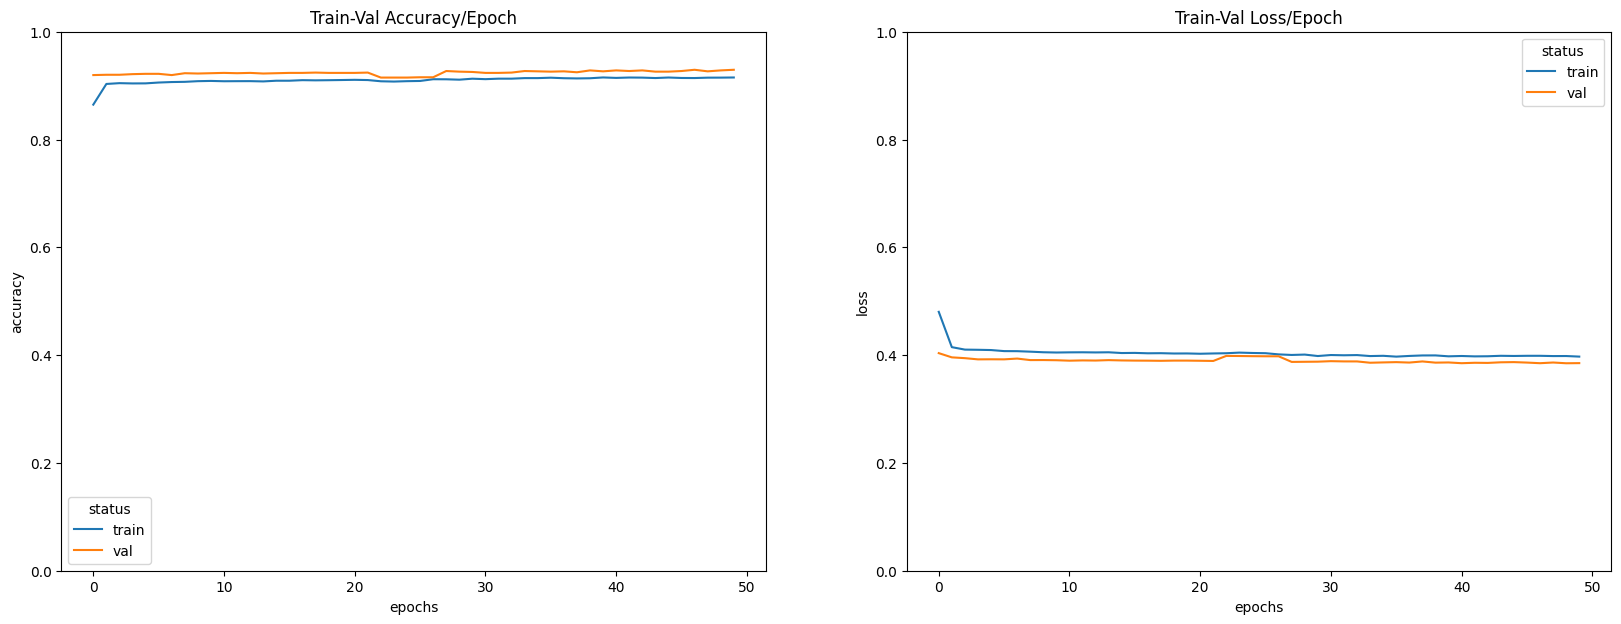

In [17]:
# Draw the plot
draw_plot(accuracy_stats, loss_stats)

# Test the model
y_pred_list = test_model(test_loader, model)

In [18]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("accuracy of test data: ", accuracy_score(y_test_lr_predicted, y_pred_list))
print(classification_report(y_test_lr_predicted, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

accuracy of test data:  0.9169175544233441
              precision    recall  f1-score   support

      Benign     0.8985    0.9986    0.9459     12571
   Malicious     0.9948    0.6984    0.8206      4701

    accuracy                         0.9169     17272
   macro avg     0.9467    0.8485    0.8833     17272
weighted avg     0.9247    0.9169    0.9118     17272



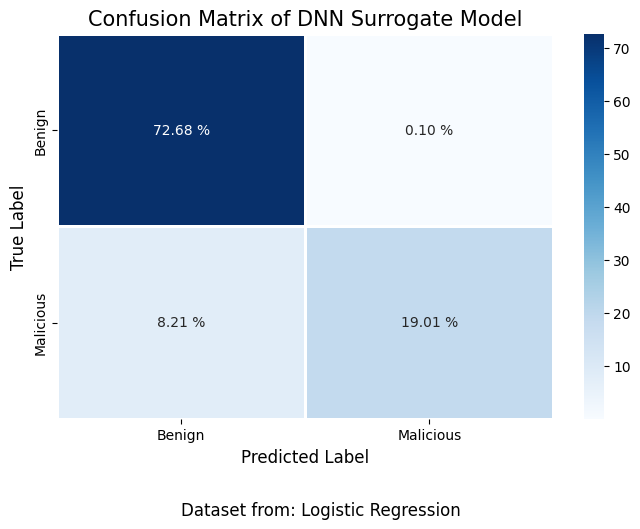

In [19]:
# draw confusion matrix
draw_confusion_matrix(y_test_lr_predicted, y_pred_list, model, 'DNN', 'Logistic Regression')

### Train for Decision Tree Predicted Data

In [20]:
train_dataset = ClassifierDataset(torch.tensor(np.array(X_train_dt_predicted)).float(), torch.tensor(np.array(y_train_dt_predicted)).long())
val_dataset = ClassifierDataset(torch.tensor(np.array(X_val_dt_predicted)).float(), torch.tensor(np.array(y_val_dt_predicted)).long())
test_dataset = ClassifierDataset(torch.tensor(np.array(X_test_dt_predicted)).float(), torch.tensor(np.array(y_test_dt_predicted)).long())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [21]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from datetime import datetime


# Initialize network
model = DNN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# accuracy, loss status for each epoch
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train Network
for epoch in range(num_epochs):
    # train model
    train_epoch_loss, train_epoch_acc = train_for_one_epoch(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # validate model
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            val_loss = criterion(voutputs, vlabels)
            val_acc = (voutputs.argmax(1) == vlabels).float().sum() / len(vlabels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    avg_vloss = val_epoch_loss/len(val_loader)


    # save the accuracy and loss for each epoch   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../surrogate_model/surrogate_DNN_model/surrogateDNN_model_fromDT_{}_{}'.format(timestamp, epoch) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_epoch_acc/len(val_loader):.4f}')


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Begin training.


100%|██████████| 566/566 [00:01<00:00, 540.11it/s]


Epoch 1: | Train Loss: 0.40012 | Val Loss: 0.37566 | Train Acc: 0.9259| Val Acc: 0.9367


100%|██████████| 566/566 [00:01<00:00, 537.50it/s]


Epoch 2: | Train Loss: 0.36884 | Val Loss: 0.37471 | Train Acc: 0.9445| Val Acc: 0.9385


100%|██████████| 566/566 [00:01<00:00, 539.91it/s]


Epoch 3: | Train Loss: 0.36694 | Val Loss: 0.37174 | Train Acc: 0.9461| Val Acc: 0.9404


100%|██████████| 566/566 [00:01<00:00, 512.57it/s]


Epoch 4: | Train Loss: 0.36496 | Val Loss: 0.36999 | Train Acc: 0.9483| Val Acc: 0.9427


100%|██████████| 566/566 [00:01<00:00, 509.60it/s]


Epoch 5: | Train Loss: 0.36475 | Val Loss: 0.36915 | Train Acc: 0.9485| Val Acc: 0.9432


100%|██████████| 566/566 [00:01<00:00, 523.94it/s]


Epoch 6: | Train Loss: 0.36409 | Val Loss: 0.36953 | Train Acc: 0.9490| Val Acc: 0.9427


100%|██████████| 566/566 [00:01<00:00, 548.30it/s]


Epoch 7: | Train Loss: 0.36321 | Val Loss: 0.36959 | Train Acc: 0.9496| Val Acc: 0.9429


100%|██████████| 566/566 [00:01<00:00, 479.89it/s]


Epoch 8: | Train Loss: 0.36310 | Val Loss: 0.36891 | Train Acc: 0.9498| Val Acc: 0.9432


100%|██████████| 566/566 [00:01<00:00, 542.99it/s]


Epoch 9: | Train Loss: 0.36252 | Val Loss: 0.36792 | Train Acc: 0.9505| Val Acc: 0.9454


100%|██████████| 566/566 [00:01<00:00, 536.90it/s]


Epoch 10: | Train Loss: 0.36224 | Val Loss: 0.36782 | Train Acc: 0.9502| Val Acc: 0.9454


100%|██████████| 566/566 [00:01<00:00, 522.99it/s]


Epoch 11: | Train Loss: 0.36193 | Val Loss: 0.36801 | Train Acc: 0.9508| Val Acc: 0.9439


100%|██████████| 566/566 [00:01<00:00, 526.88it/s]


Epoch 12: | Train Loss: 0.36164 | Val Loss: 0.36824 | Train Acc: 0.9510| Val Acc: 0.9437


100%|██████████| 566/566 [00:01<00:00, 523.95it/s]


Epoch 13: | Train Loss: 0.36106 | Val Loss: 0.36777 | Train Acc: 0.9513| Val Acc: 0.9434


100%|██████████| 566/566 [00:01<00:00, 517.25it/s]


Epoch 14: | Train Loss: 0.36111 | Val Loss: 0.36697 | Train Acc: 0.9514| Val Acc: 0.9459


100%|██████████| 566/566 [00:01<00:00, 430.19it/s]


Epoch 15: | Train Loss: 0.36089 | Val Loss: 0.36738 | Train Acc: 0.9519| Val Acc: 0.9454


100%|██████████| 566/566 [00:01<00:00, 439.97it/s]


Epoch 16: | Train Loss: 0.36020 | Val Loss: 0.36724 | Train Acc: 0.9524| Val Acc: 0.9449


100%|██████████| 566/566 [00:01<00:00, 510.04it/s]


Epoch 17: | Train Loss: 0.36064 | Val Loss: 0.36653 | Train Acc: 0.9516| Val Acc: 0.9467


100%|██████████| 566/566 [00:01<00:00, 511.80it/s]


Epoch 18: | Train Loss: 0.36068 | Val Loss: 0.36799 | Train Acc: 0.9519| Val Acc: 0.9439


100%|██████████| 566/566 [00:01<00:00, 508.30it/s]


Epoch 19: | Train Loss: 0.36043 | Val Loss: 0.36726 | Train Acc: 0.9518| Val Acc: 0.9434


100%|██████████| 566/566 [00:01<00:00, 534.85it/s]


Epoch 20: | Train Loss: 0.35976 | Val Loss: 0.36698 | Train Acc: 0.9528| Val Acc: 0.9444


100%|██████████| 566/566 [00:01<00:00, 535.04it/s]


Epoch 21: | Train Loss: 0.36057 | Val Loss: 0.36862 | Train Acc: 0.9523| Val Acc: 0.9434


100%|██████████| 566/566 [00:01<00:00, 544.54it/s]


Epoch 22: | Train Loss: 0.36032 | Val Loss: 0.36796 | Train Acc: 0.9522| Val Acc: 0.9449


100%|██████████| 566/566 [00:01<00:00, 543.58it/s]


Epoch 23: | Train Loss: 0.36022 | Val Loss: 0.36676 | Train Acc: 0.9525| Val Acc: 0.9457


100%|██████████| 566/566 [00:01<00:00, 534.48it/s]


Epoch 24: | Train Loss: 0.35987 | Val Loss: 0.36675 | Train Acc: 0.9529| Val Acc: 0.9459


100%|██████████| 566/566 [00:01<00:00, 544.07it/s]


Epoch 25: | Train Loss: 0.36037 | Val Loss: 0.36754 | Train Acc: 0.9520| Val Acc: 0.9437


100%|██████████| 566/566 [00:01<00:00, 538.14it/s]


Epoch 26: | Train Loss: 0.35967 | Val Loss: 0.36787 | Train Acc: 0.9534| Val Acc: 0.9439


100%|██████████| 566/566 [00:01<00:00, 535.18it/s]


Epoch 27: | Train Loss: 0.35964 | Val Loss: 0.36781 | Train Acc: 0.9533| Val Acc: 0.9442


100%|██████████| 566/566 [00:01<00:00, 537.88it/s]


Epoch 28: | Train Loss: 0.35987 | Val Loss: 0.36700 | Train Acc: 0.9527| Val Acc: 0.9447


100%|██████████| 566/566 [00:01<00:00, 527.91it/s]


Epoch 29: | Train Loss: 0.35948 | Val Loss: 0.36919 | Train Acc: 0.9531| Val Acc: 0.9442


100%|██████████| 566/566 [00:01<00:00, 529.35it/s]


Epoch 30: | Train Loss: 0.35979 | Val Loss: 0.36863 | Train Acc: 0.9532| Val Acc: 0.9444


100%|██████████| 566/566 [00:01<00:00, 543.06it/s]


Epoch 31: | Train Loss: 0.36022 | Val Loss: 0.36735 | Train Acc: 0.9528| Val Acc: 0.9447


100%|██████████| 566/566 [00:01<00:00, 534.77it/s]


Epoch 32: | Train Loss: 0.35969 | Val Loss: 0.36840 | Train Acc: 0.9534| Val Acc: 0.9447


100%|██████████| 566/566 [00:01<00:00, 510.99it/s]


Epoch 33: | Train Loss: 0.35956 | Val Loss: 0.36733 | Train Acc: 0.9532| Val Acc: 0.9447


100%|██████████| 566/566 [00:01<00:00, 469.76it/s]


Epoch 34: | Train Loss: 0.35965 | Val Loss: 0.36608 | Train Acc: 0.9531| Val Acc: 0.9471


100%|██████████| 566/566 [00:01<00:00, 523.30it/s]


Epoch 35: | Train Loss: 0.35920 | Val Loss: 0.36603 | Train Acc: 0.9532| Val Acc: 0.9464


100%|██████████| 566/566 [00:01<00:00, 527.12it/s]


Epoch 36: | Train Loss: 0.35969 | Val Loss: 0.36762 | Train Acc: 0.9533| Val Acc: 0.9444


100%|██████████| 566/566 [00:01<00:00, 537.38it/s]


Epoch 37: | Train Loss: 0.35989 | Val Loss: 0.36631 | Train Acc: 0.9527| Val Acc: 0.9467


100%|██████████| 566/566 [00:01<00:00, 532.33it/s]


Epoch 38: | Train Loss: 0.35943 | Val Loss: 0.36542 | Train Acc: 0.9531| Val Acc: 0.9469


100%|██████████| 566/566 [00:01<00:00, 529.35it/s]


Epoch 39: | Train Loss: 0.35916 | Val Loss: 0.36630 | Train Acc: 0.9532| Val Acc: 0.9469


100%|██████████| 566/566 [00:01<00:00, 521.71it/s]


Epoch 40: | Train Loss: 0.35973 | Val Loss: 0.36724 | Train Acc: 0.9529| Val Acc: 0.9452


100%|██████████| 566/566 [00:01<00:00, 528.36it/s]


Epoch 41: | Train Loss: 0.35933 | Val Loss: 0.36793 | Train Acc: 0.9532| Val Acc: 0.9442


100%|██████████| 566/566 [00:01<00:00, 546.54it/s]


Epoch 42: | Train Loss: 0.35964 | Val Loss: 0.36646 | Train Acc: 0.9533| Val Acc: 0.9467


100%|██████████| 566/566 [00:01<00:00, 530.34it/s]


Epoch 43: | Train Loss: 0.35915 | Val Loss: 0.36718 | Train Acc: 0.9536| Val Acc: 0.9447


100%|██████████| 566/566 [00:01<00:00, 534.83it/s]


Epoch 44: | Train Loss: 0.35935 | Val Loss: 0.36642 | Train Acc: 0.9532| Val Acc: 0.9464


100%|██████████| 566/566 [00:01<00:00, 539.68it/s]


Epoch 45: | Train Loss: 0.35884 | Val Loss: 0.36668 | Train Acc: 0.9537| Val Acc: 0.9449


100%|██████████| 566/566 [00:01<00:00, 537.36it/s]


Epoch 46: | Train Loss: 0.35905 | Val Loss: 0.36584 | Train Acc: 0.9535| Val Acc: 0.9474


100%|██████████| 566/566 [00:01<00:00, 532.83it/s]


Epoch 47: | Train Loss: 0.35906 | Val Loss: 0.36573 | Train Acc: 0.9533| Val Acc: 0.9467


100%|██████████| 566/566 [00:01<00:00, 461.40it/s]


Epoch 48: | Train Loss: 0.35885 | Val Loss: 0.36718 | Train Acc: 0.9544| Val Acc: 0.9444


100%|██████████| 566/566 [00:01<00:00, 513.12it/s]


Epoch 49: | Train Loss: 0.35902 | Val Loss: 0.36574 | Train Acc: 0.9534| Val Acc: 0.9474


100%|██████████| 566/566 [00:01<00:00, 516.30it/s]


Epoch 50: | Train Loss: 0.35861 | Val Loss: 0.36576 | Train Acc: 0.9540| Val Acc: 0.9476
Accuracy on training set: 95.60
Accuracy on test set: 86.62


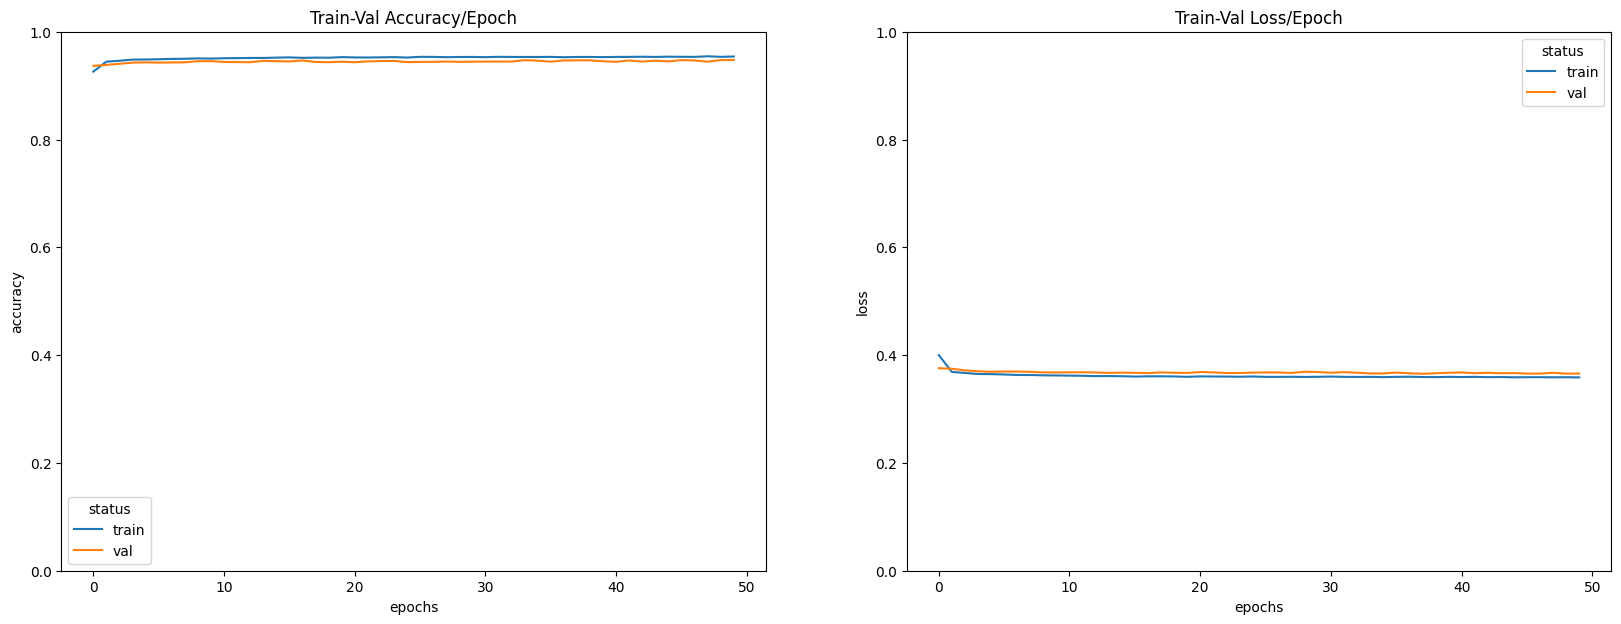

In [22]:
# Draw the plot
draw_plot(accuracy_stats, loss_stats)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Test the model
y_pred_list = test_model(test_loader, model)

# test accuracy
print("accuracy of test data: ", accuracy_score(y_test_dt_predicted, y_pred_list))
print(classification_report(y_test_dt_predicted, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

accuracy of test data:  0.8661996294580825
              precision    recall  f1-score   support

      Benign     0.8473    0.9956    0.9155     12571
   Malicious     0.9780    0.5201    0.6791      4701

    accuracy                         0.8662     17272
   macro avg     0.9126    0.7579    0.7973     17272
weighted avg     0.8829    0.8662    0.8511     17272



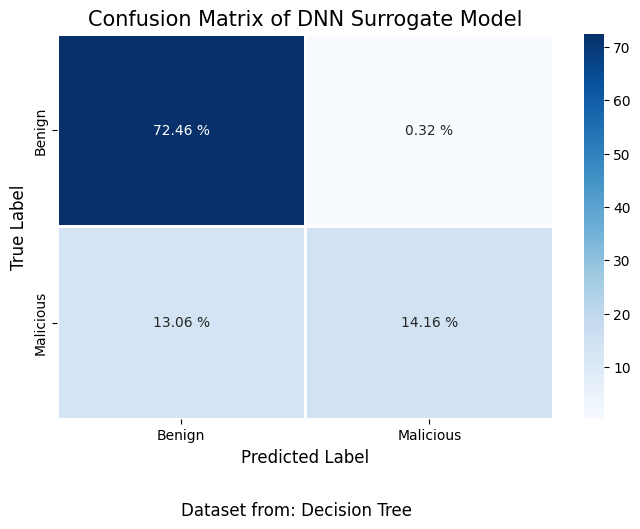

In [24]:
# draw confusion matrix
draw_confusion_matrix(y_test_dt_predicted, y_pred_list, model, 'DNN', 'Decision Tree')

### Train for Xgboost Predicted Data

In [25]:
train_dataset = ClassifierDataset(torch.tensor(np.array(X_train_xgb_predicted)).float(), torch.tensor(np.array(y_train_xgb_predicted)).long())
val_dataset = ClassifierDataset(torch.tensor(np.array(X_val_xgb_predicted)).float(), torch.tensor(np.array(y_val_xgb_predicted)).long())
test_dataset = ClassifierDataset(torch.tensor(np.array(X_test_xgb_predicted)).float(), torch.tensor(np.array(y_test_xgb_predicted)).long())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [26]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from datetime import datetime


# Initialize network
model = DNN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# accuracy, loss status for each epoch
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train Network
for epoch in range(num_epochs):
    # train model
    train_epoch_loss, train_epoch_acc = train_for_one_epoch(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # validate model
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            val_loss = criterion(voutputs, vlabels)
            val_acc = (voutputs.argmax(1) == vlabels).float().sum() / len(vlabels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    avg_vloss = val_epoch_loss/len(val_loader)


    # save the accuracy and loss for each epoch   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../surrogate_model/surrogate_DNN_model/surrogateDNN_model_fromXgboost_{}_{}'.format(timestamp, epoch) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_epoch_acc/len(val_loader):.4f}')


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Begin training.


100%|██████████| 566/566 [00:01<00:00, 525.77it/s]


Epoch 1: | Train Loss: 0.50016 | Val Loss: 0.46780 | Train Acc: 0.8230| Val Acc: 0.8452


100%|██████████| 566/566 [00:01<00:00, 517.25it/s]


Epoch 2: | Train Loss: 0.46089 | Val Loss: 0.46031 | Train Acc: 0.8507| Val Acc: 0.8432


100%|██████████| 566/566 [00:01<00:00, 506.60it/s]


Epoch 3: | Train Loss: 0.45606 | Val Loss: 0.46166 | Train Acc: 0.8555| Val Acc: 0.8526


100%|██████████| 566/566 [00:01<00:00, 486.14it/s]


Epoch 4: | Train Loss: 0.45427 | Val Loss: 0.45777 | Train Acc: 0.8575| Val Acc: 0.8474


100%|██████████| 566/566 [00:01<00:00, 534.34it/s]


Epoch 5: | Train Loss: 0.45261 | Val Loss: 0.45624 | Train Acc: 0.8586| Val Acc: 0.8511


100%|██████████| 566/566 [00:01<00:00, 544.94it/s]


Epoch 6: | Train Loss: 0.45114 | Val Loss: 0.46476 | Train Acc: 0.8601| Val Acc: 0.8479


100%|██████████| 566/566 [00:01<00:00, 528.36it/s]


Epoch 7: | Train Loss: 0.45307 | Val Loss: 0.46478 | Train Acc: 0.8593| Val Acc: 0.8484


100%|██████████| 566/566 [00:01<00:00, 554.78it/s]


Epoch 8: | Train Loss: 0.45245 | Val Loss: 0.46217 | Train Acc: 0.8601| Val Acc: 0.8514


100%|██████████| 566/566 [00:01<00:00, 533.84it/s]


Epoch 9: | Train Loss: 0.45258 | Val Loss: 0.46185 | Train Acc: 0.8600| Val Acc: 0.8526


100%|██████████| 566/566 [00:01<00:00, 529.57it/s]


Epoch 10: | Train Loss: 0.45165 | Val Loss: 0.46092 | Train Acc: 0.8610| Val Acc: 0.8521


100%|██████████| 566/566 [00:01<00:00, 491.63it/s]


Epoch 11: | Train Loss: 0.45014 | Val Loss: 0.46062 | Train Acc: 0.8616| Val Acc: 0.8536


100%|██████████| 566/566 [00:01<00:00, 427.01it/s]


Epoch 12: | Train Loss: 0.45105 | Val Loss: 0.46036 | Train Acc: 0.8610| Val Acc: 0.8536


100%|██████████| 566/566 [00:01<00:00, 517.95it/s]


Epoch 13: | Train Loss: 0.44990 | Val Loss: 0.45953 | Train Acc: 0.8619| Val Acc: 0.8531


100%|██████████| 566/566 [00:01<00:00, 452.34it/s]


Epoch 14: | Train Loss: 0.45025 | Val Loss: 0.45891 | Train Acc: 0.8624| Val Acc: 0.8548


100%|██████████| 566/566 [00:01<00:00, 538.41it/s]


Epoch 15: | Train Loss: 0.44943 | Val Loss: 0.45845 | Train Acc: 0.8639| Val Acc: 0.8553


100%|██████████| 566/566 [00:01<00:00, 533.84it/s]


Epoch 16: | Train Loss: 0.44830 | Val Loss: 0.45772 | Train Acc: 0.8646| Val Acc: 0.8561


100%|██████████| 566/566 [00:01<00:00, 484.07it/s]


Epoch 17: | Train Loss: 0.44828 | Val Loss: 0.45844 | Train Acc: 0.8650| Val Acc: 0.8553


100%|██████████| 566/566 [00:01<00:00, 546.74it/s]


Epoch 18: | Train Loss: 0.44743 | Val Loss: 0.45734 | Train Acc: 0.8660| Val Acc: 0.8563


100%|██████████| 566/566 [00:01<00:00, 547.27it/s]


Epoch 19: | Train Loss: 0.44808 | Val Loss: 0.45760 | Train Acc: 0.8650| Val Acc: 0.8556


100%|██████████| 566/566 [00:01<00:00, 563.06it/s]


Epoch 20: | Train Loss: 0.44723 | Val Loss: 0.45757 | Train Acc: 0.8659| Val Acc: 0.8563


100%|██████████| 566/566 [00:01<00:00, 548.33it/s]


Epoch 21: | Train Loss: 0.44817 | Val Loss: 0.45701 | Train Acc: 0.8649| Val Acc: 0.8571


100%|██████████| 566/566 [00:01<00:00, 533.34it/s]


Epoch 22: | Train Loss: 0.44688 | Val Loss: 0.46006 | Train Acc: 0.8660| Val Acc: 0.8526


100%|██████████| 566/566 [00:01<00:00, 534.35it/s]


Epoch 23: | Train Loss: 0.44707 | Val Loss: 0.45960 | Train Acc: 0.8649| Val Acc: 0.8531


100%|██████████| 566/566 [00:01<00:00, 547.79it/s]


Epoch 24: | Train Loss: 0.44634 | Val Loss: 0.45728 | Train Acc: 0.8655| Val Acc: 0.8561


100%|██████████| 566/566 [00:01<00:00, 531.83it/s]


Epoch 25: | Train Loss: 0.44687 | Val Loss: 0.45744 | Train Acc: 0.8656| Val Acc: 0.8558


100%|██████████| 566/566 [00:01<00:00, 534.85it/s]


Epoch 26: | Train Loss: 0.44750 | Val Loss: 0.45533 | Train Acc: 0.8653| Val Acc: 0.8571


100%|██████████| 566/566 [00:01<00:00, 515.84it/s]


Epoch 27: | Train Loss: 0.44706 | Val Loss: 0.45808 | Train Acc: 0.8651| Val Acc: 0.8556


100%|██████████| 566/566 [00:01<00:00, 516.31it/s]


Epoch 28: | Train Loss: 0.44640 | Val Loss: 0.45714 | Train Acc: 0.8664| Val Acc: 0.8566


100%|██████████| 566/566 [00:01<00:00, 526.39it/s]


Epoch 29: | Train Loss: 0.44692 | Val Loss: 0.45605 | Train Acc: 0.8658| Val Acc: 0.8568


100%|██████████| 566/566 [00:01<00:00, 515.04it/s]


Epoch 30: | Train Loss: 0.44555 | Val Loss: 0.45735 | Train Acc: 0.8669| Val Acc: 0.8561


100%|██████████| 566/566 [00:01<00:00, 529.95it/s]


Epoch 31: | Train Loss: 0.44566 | Val Loss: 0.45600 | Train Acc: 0.8672| Val Acc: 0.8573


100%|██████████| 566/566 [00:01<00:00, 429.81it/s]


Epoch 32: | Train Loss: 0.44486 | Val Loss: 0.45637 | Train Acc: 0.8679| Val Acc: 0.8571


100%|██████████| 566/566 [00:01<00:00, 528.35it/s]


Epoch 33: | Train Loss: 0.44497 | Val Loss: 0.45574 | Train Acc: 0.8675| Val Acc: 0.8573


100%|██████████| 566/566 [00:01<00:00, 525.89it/s]


Epoch 34: | Train Loss: 0.44503 | Val Loss: 0.45707 | Train Acc: 0.8669| Val Acc: 0.8561


100%|██████████| 566/566 [00:01<00:00, 528.32it/s]


Epoch 35: | Train Loss: 0.44253 | Val Loss: 0.45705 | Train Acc: 0.8687| Val Acc: 0.8558


100%|██████████| 566/566 [00:01<00:00, 540.19it/s]


Epoch 36: | Train Loss: 0.44501 | Val Loss: 0.45669 | Train Acc: 0.8675| Val Acc: 0.8558


100%|██████████| 566/566 [00:01<00:00, 527.37it/s]


Epoch 37: | Train Loss: 0.44417 | Val Loss: 0.45626 | Train Acc: 0.8679| Val Acc: 0.8561


100%|██████████| 566/566 [00:01<00:00, 462.31it/s]


Epoch 38: | Train Loss: 0.44436 | Val Loss: 0.45604 | Train Acc: 0.8673| Val Acc: 0.8573


100%|██████████| 566/566 [00:01<00:00, 546.74it/s]


Epoch 39: | Train Loss: 0.44433 | Val Loss: 0.45510 | Train Acc: 0.8672| Val Acc: 0.8588


100%|██████████| 566/566 [00:01<00:00, 541.50it/s]


Epoch 40: | Train Loss: 0.44234 | Val Loss: 0.45611 | Train Acc: 0.8690| Val Acc: 0.8571


100%|██████████| 566/566 [00:01<00:00, 540.47it/s]


Epoch 41: | Train Loss: 0.44405 | Val Loss: 0.45539 | Train Acc: 0.8684| Val Acc: 0.8583


100%|██████████| 566/566 [00:01<00:00, 534.35it/s]


Epoch 42: | Train Loss: 0.44373 | Val Loss: 0.45621 | Train Acc: 0.8677| Val Acc: 0.8566


100%|██████████| 566/566 [00:01<00:00, 510.71it/s]


Epoch 43: | Train Loss: 0.44254 | Val Loss: 0.45563 | Train Acc: 0.8690| Val Acc: 0.8566


100%|██████████| 566/566 [00:01<00:00, 552.61it/s]


Epoch 44: | Train Loss: 0.44170 | Val Loss: 0.45310 | Train Acc: 0.8691| Val Acc: 0.8568


100%|██████████| 566/566 [00:01<00:00, 516.31it/s]


Epoch 45: | Train Loss: 0.44016 | Val Loss: 0.44940 | Train Acc: 0.8705| Val Acc: 0.8596


100%|██████████| 566/566 [00:01<00:00, 539.44it/s]


Epoch 46: | Train Loss: 0.43878 | Val Loss: 0.44374 | Train Acc: 0.8712| Val Acc: 0.8680


100%|██████████| 566/566 [00:01<00:00, 540.99it/s]


Epoch 47: | Train Loss: 0.43898 | Val Loss: 0.44427 | Train Acc: 0.8717| Val Acc: 0.8677


100%|██████████| 566/566 [00:01<00:00, 495.08it/s]


Epoch 48: | Train Loss: 0.43488 | Val Loss: 0.44314 | Train Acc: 0.8759| Val Acc: 0.8697


100%|██████████| 566/566 [00:01<00:00, 518.20it/s]


Epoch 49: | Train Loss: 0.43317 | Val Loss: 0.44135 | Train Acc: 0.8767| Val Acc: 0.8712


100%|██████████| 566/566 [00:01<00:00, 533.84it/s]


Epoch 50: | Train Loss: 0.43403 | Val Loss: 0.44275 | Train Acc: 0.8758| Val Acc: 0.8682
Accuracy on training set: 88.26
Accuracy on test set: 86.32


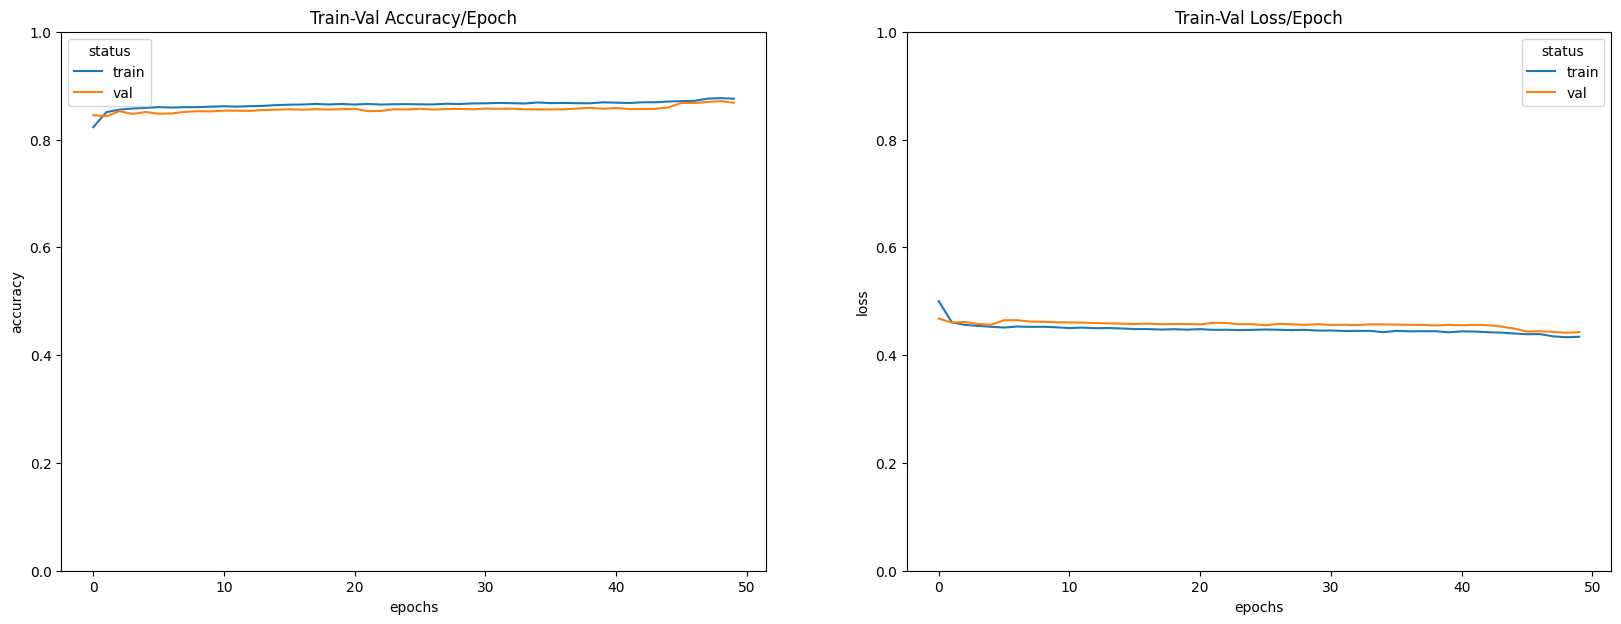

In [27]:
# Draw the plot
draw_plot(accuracy_stats, loss_stats)

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Test the model
y_pred_list = test_model(test_loader, model)

# test accuracy
print("accuracy of test data: ", accuracy_score(y_test_xgb_predicted, y_pred_list))
print(classification_report(y_test_xgb_predicted, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

accuracy of test data:  0.8631889763779528
              precision    recall  f1-score   support

      Benign     0.8936    0.9217    0.9075     12571
   Malicious     0.7715    0.7067    0.7376      4701

    accuracy                         0.8632     17272
   macro avg     0.8326    0.8142    0.8226     17272
weighted avg     0.8604    0.8632    0.8612     17272



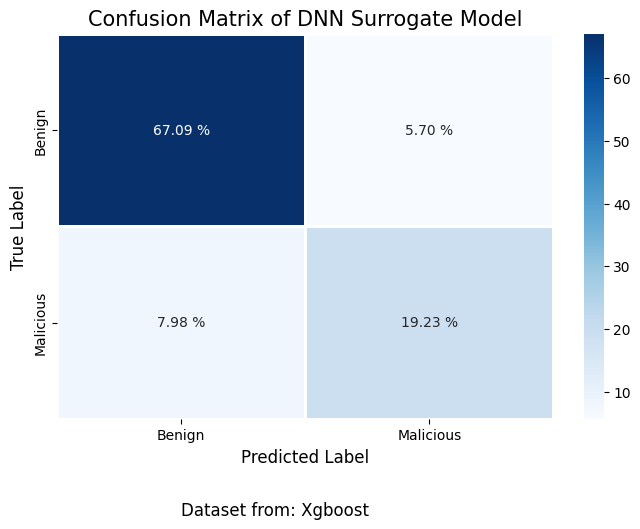

In [29]:
# draw confusion matrix
draw_confusion_matrix(y_test_xgb_predicted, y_pred_list, model, 'DNN', 'Xgboost')

### Train for DNN Predicted Data

In [30]:
train_dataset = ClassifierDataset(torch.tensor(np.array(X_train_dnn_predicted)).float(), torch.tensor(np.array(y_train_dnn_predicted)).long())
val_dataset = ClassifierDataset(torch.tensor(np.array(X_val_dnn_predicted)).float(), torch.tensor(np.array(y_val_dnn_predicted)).long())
test_dataset = ClassifierDataset(torch.tensor(np.array(X_test_dnn_predicted)).float(), torch.tensor(np.array(y_test_dnn_predicted)).long())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [31]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from datetime import datetime


# Initialize network
model = DNN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# accuracy, loss status for each epoch
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train Network
for epoch in range(num_epochs):
    # train model
    train_epoch_loss, train_epoch_acc = train_for_one_epoch(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # validate model
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            val_loss = criterion(voutputs, vlabels)
            val_acc = (voutputs.argmax(1) == vlabels).float().sum() / len(vlabels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    avg_vloss = val_epoch_loss/len(val_loader)


    # save the accuracy and loss for each epoch   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../surrogate_model/surrogate_DNN_model/surrogateDNN_model_fromDNN_{}_{}'.format(timestamp, epoch) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_epoch_acc/len(val_loader):.4f}')


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Begin training.


  0%|          | 0/566 [00:00<?, ?it/s]

100%|██████████| 566/566 [00:01<00:00, 517.24it/s]


Epoch 1: | Train Loss: 0.43902 | Val Loss: 0.34716 | Train Acc: 0.8905| Val Acc: 0.9677


100%|██████████| 566/566 [00:01<00:00, 510.49it/s]


Epoch 2: | Train Loss: 0.37680 | Val Loss: 0.34322 | Train Acc: 0.9355| Val Acc: 0.9670


100%|██████████| 566/566 [00:01<00:00, 460.08it/s]


Epoch 3: | Train Loss: 0.37103 | Val Loss: 0.39399 | Train Acc: 0.9408| Val Acc: 0.9184


100%|██████████| 566/566 [00:01<00:00, 511.17it/s]


Epoch 4: | Train Loss: 0.37687 | Val Loss: 0.36927 | Train Acc: 0.9335| Val Acc: 0.9370


100%|██████████| 566/566 [00:01<00:00, 523.52it/s]


Epoch 5: | Train Loss: 0.37885 | Val Loss: 0.41014 | Train Acc: 0.9316| Val Acc: 0.9025


100%|██████████| 566/566 [00:01<00:00, 529.12it/s]


Epoch 6: | Train Loss: 0.39240 | Val Loss: 0.40906 | Train Acc: 0.9189| Val Acc: 0.9037


100%|██████████| 566/566 [00:01<00:00, 533.96it/s]


Epoch 7: | Train Loss: 0.38084 | Val Loss: 0.40979 | Train Acc: 0.9287| Val Acc: 0.9037


100%|██████████| 566/566 [00:01<00:00, 459.50it/s]


Epoch 8: | Train Loss: 0.38194 | Val Loss: 0.40790 | Train Acc: 0.9278| Val Acc: 0.9057


100%|██████████| 566/566 [00:01<00:00, 530.93it/s]


Epoch 9: | Train Loss: 0.37882 | Val Loss: 0.40236 | Train Acc: 0.9317| Val Acc: 0.9057


100%|██████████| 566/566 [00:01<00:00, 526.18it/s]


Epoch 10: | Train Loss: 0.37266 | Val Loss: 0.36662 | Train Acc: 0.9366| Val Acc: 0.9226


100%|██████████| 566/566 [00:01<00:00, 449.42it/s]


Epoch 11: | Train Loss: 0.36702 | Val Loss: 0.34681 | Train Acc: 0.9422| Val Acc: 0.9640


100%|██████████| 566/566 [00:01<00:00, 537.55it/s]


Epoch 12: | Train Loss: 0.35911 | Val Loss: 0.34735 | Train Acc: 0.9504| Val Acc: 0.9618


100%|██████████| 566/566 [00:01<00:00, 512.56it/s]


Epoch 13: | Train Loss: 0.35733 | Val Loss: 0.34815 | Train Acc: 0.9522| Val Acc: 0.9625


100%|██████████| 566/566 [00:01<00:00, 530.17it/s]


Epoch 14: | Train Loss: 0.35370 | Val Loss: 0.34321 | Train Acc: 0.9555| Val Acc: 0.9667


100%|██████████| 566/566 [00:01<00:00, 529.21it/s]


Epoch 15: | Train Loss: 0.34581 | Val Loss: 0.33420 | Train Acc: 0.9648| Val Acc: 0.9759


100%|██████████| 566/566 [00:01<00:00, 473.33it/s]


Epoch 16: | Train Loss: 0.34460 | Val Loss: 0.33478 | Train Acc: 0.9671| Val Acc: 0.9772


100%|██████████| 566/566 [00:01<00:00, 543.58it/s]


Epoch 17: | Train Loss: 0.34415 | Val Loss: 0.33197 | Train Acc: 0.9685| Val Acc: 0.9799


100%|██████████| 566/566 [00:01<00:00, 528.39it/s]


Epoch 18: | Train Loss: 0.34337 | Val Loss: 0.33228 | Train Acc: 0.9685| Val Acc: 0.9782


100%|██████████| 566/566 [00:01<00:00, 539.17it/s]


Epoch 19: | Train Loss: 0.34307 | Val Loss: 0.33180 | Train Acc: 0.9680| Val Acc: 0.9789


100%|██████████| 566/566 [00:01<00:00, 540.99it/s]


Epoch 20: | Train Loss: 0.34322 | Val Loss: 0.34342 | Train Acc: 0.9684| Val Acc: 0.9670


100%|██████████| 566/566 [00:01<00:00, 459.68it/s]


Epoch 21: | Train Loss: 0.35482 | Val Loss: 0.34273 | Train Acc: 0.9536| Val Acc: 0.9682


100%|██████████| 566/566 [00:01<00:00, 535.88it/s]


Epoch 22: | Train Loss: 0.35423 | Val Loss: 0.34521 | Train Acc: 0.9545| Val Acc: 0.9670


100%|██████████| 566/566 [00:01<00:00, 555.85it/s]


Epoch 23: | Train Loss: 0.35217 | Val Loss: 0.34101 | Train Acc: 0.9577| Val Acc: 0.9710


100%|██████████| 566/566 [00:01<00:00, 542.62it/s]


Epoch 24: | Train Loss: 0.35072 | Val Loss: 0.34355 | Train Acc: 0.9593| Val Acc: 0.9667


100%|██████████| 566/566 [00:01<00:00, 554.33it/s]


Epoch 25: | Train Loss: 0.35298 | Val Loss: 0.34273 | Train Acc: 0.9564| Val Acc: 0.9682


100%|██████████| 566/566 [00:01<00:00, 545.87it/s]


Epoch 26: | Train Loss: 0.35182 | Val Loss: 0.33969 | Train Acc: 0.9578| Val Acc: 0.9710


100%|██████████| 566/566 [00:01<00:00, 535.86it/s]


Epoch 27: | Train Loss: 0.35148 | Val Loss: 0.33957 | Train Acc: 0.9582| Val Acc: 0.9720


100%|██████████| 566/566 [00:01<00:00, 536.41it/s]


Epoch 28: | Train Loss: 0.35174 | Val Loss: 0.34095 | Train Acc: 0.9575| Val Acc: 0.9695


100%|██████████| 566/566 [00:01<00:00, 543.60it/s]


Epoch 29: | Train Loss: 0.35167 | Val Loss: 0.34496 | Train Acc: 0.9581| Val Acc: 0.9665


100%|██████████| 566/566 [00:01<00:00, 542.02it/s]


Epoch 30: | Train Loss: 0.35078 | Val Loss: 0.34149 | Train Acc: 0.9591| Val Acc: 0.9692


100%|██████████| 566/566 [00:01<00:00, 554.15it/s]


Epoch 31: | Train Loss: 0.35387 | Val Loss: 0.34496 | Train Acc: 0.9565| Val Acc: 0.9667


100%|██████████| 566/566 [00:01<00:00, 540.57it/s]


Epoch 32: | Train Loss: 0.35047 | Val Loss: 0.34195 | Train Acc: 0.9599| Val Acc: 0.9680


100%|██████████| 566/566 [00:01<00:00, 535.85it/s]


Epoch 33: | Train Loss: 0.35398 | Val Loss: 0.34447 | Train Acc: 0.9567| Val Acc: 0.9675


100%|██████████| 566/566 [00:01<00:00, 524.34it/s]


Epoch 34: | Train Loss: 0.35320 | Val Loss: 0.34174 | Train Acc: 0.9572| Val Acc: 0.9695


100%|██████████| 566/566 [00:01<00:00, 523.54it/s]


Epoch 35: | Train Loss: 0.35537 | Val Loss: 0.34354 | Train Acc: 0.9532| Val Acc: 0.9672


100%|██████████| 566/566 [00:01<00:00, 537.51it/s]


Epoch 36: | Train Loss: 0.37030 | Val Loss: 0.40373 | Train Acc: 0.9401| Val Acc: 0.9094


100%|██████████| 566/566 [00:01<00:00, 525.68it/s]


Epoch 37: | Train Loss: 0.36985 | Val Loss: 0.40087 | Train Acc: 0.9398| Val Acc: 0.9119


100%|██████████| 566/566 [00:01<00:00, 536.99it/s]


Epoch 38: | Train Loss: 0.36405 | Val Loss: 0.35031 | Train Acc: 0.9435| Val Acc: 0.9551


100%|██████████| 566/566 [00:01<00:00, 537.12it/s]


Epoch 39: | Train Loss: 0.36015 | Val Loss: 0.35152 | Train Acc: 0.9484| Val Acc: 0.9551


100%|██████████| 566/566 [00:01<00:00, 538.19it/s]


Epoch 40: | Train Loss: 0.35490 | Val Loss: 0.34712 | Train Acc: 0.9556| Val Acc: 0.9650


100%|██████████| 566/566 [00:01<00:00, 533.58it/s]


Epoch 41: | Train Loss: 0.35558 | Val Loss: 0.35314 | Train Acc: 0.9556| Val Acc: 0.9596


100%|██████████| 566/566 [00:01<00:00, 534.73it/s]


Epoch 42: | Train Loss: 0.36617 | Val Loss: 0.40108 | Train Acc: 0.9444| Val Acc: 0.9119


100%|██████████| 566/566 [00:01<00:00, 530.54it/s]


Epoch 43: | Train Loss: 0.37039 | Val Loss: 0.39655 | Train Acc: 0.9400| Val Acc: 0.9127


100%|██████████| 566/566 [00:01<00:00, 534.81it/s]


Epoch 44: | Train Loss: 0.36994 | Val Loss: 0.39711 | Train Acc: 0.9410| Val Acc: 0.9094


100%|██████████| 566/566 [00:01<00:00, 549.70it/s]


Epoch 45: | Train Loss: 0.37077 | Val Loss: 0.39389 | Train Acc: 0.9401| Val Acc: 0.9124


100%|██████████| 566/566 [00:01<00:00, 529.84it/s]


Epoch 46: | Train Loss: 0.37637 | Val Loss: 0.40312 | Train Acc: 0.9352| Val Acc: 0.9099


100%|██████████| 566/566 [00:01<00:00, 524.65it/s]


Epoch 47: | Train Loss: 0.37673 | Val Loss: 0.40471 | Train Acc: 0.9349| Val Acc: 0.9082


100%|██████████| 566/566 [00:01<00:00, 550.99it/s]


Epoch 48: | Train Loss: 0.37663 | Val Loss: 0.40194 | Train Acc: 0.9353| Val Acc: 0.9119


100%|██████████| 566/566 [00:01<00:00, 539.38it/s]


Epoch 49: | Train Loss: 0.37777 | Val Loss: 0.40585 | Train Acc: 0.9336| Val Acc: 0.9069


100%|██████████| 566/566 [00:01<00:00, 546.76it/s]


Epoch 50: | Train Loss: 0.37871 | Val Loss: 0.40570 | Train Acc: 0.9326| Val Acc: 0.9077
Accuracy on training set: 92.54
Accuracy on test set: 67.17


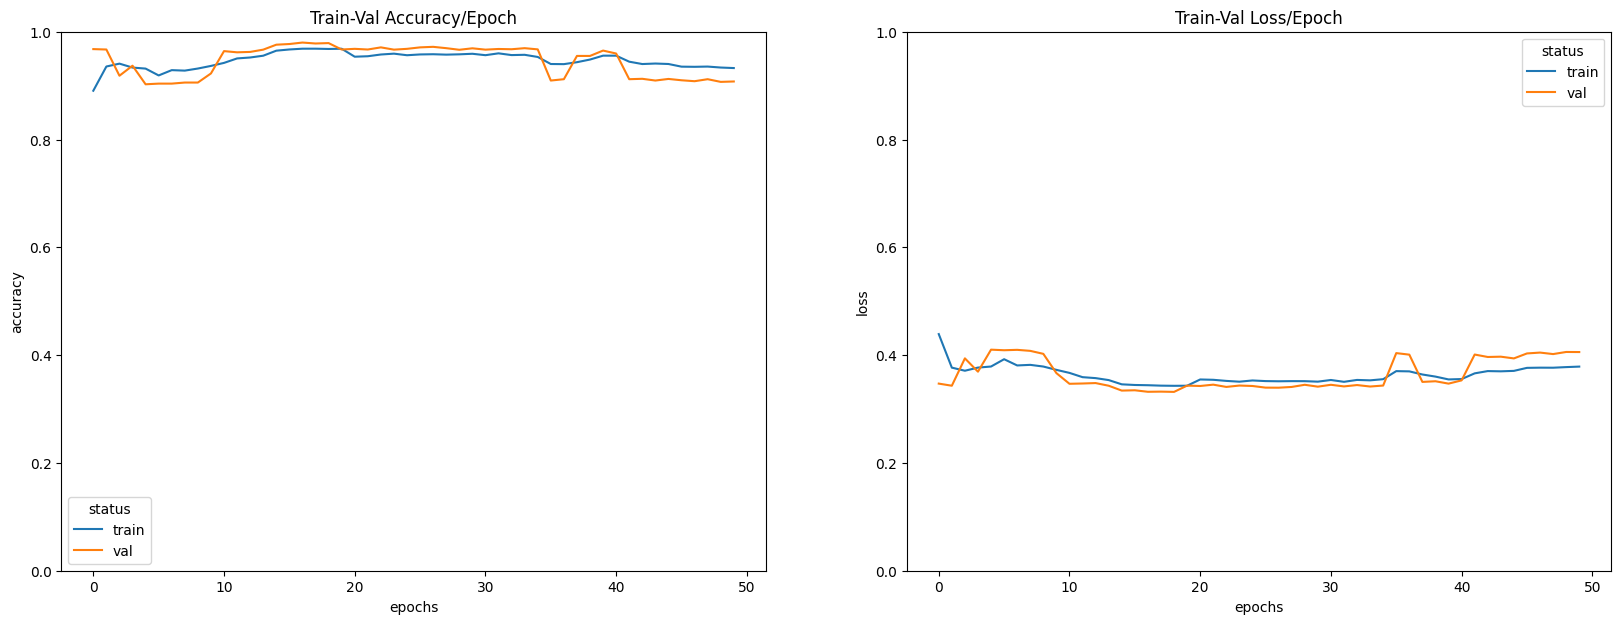

In [32]:
# Draw the plot
draw_plot(accuracy_stats, loss_stats)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Test the model
y_pred_list = test_model(test_loader, model)

# test accuracy
print("accuracy of test data: ", accuracy_score(y_test_dnn_predicted, y_pred_list))
print(classification_report(y_test_dnn_predicted, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

accuracy of test data:  0.6716651227420102
              precision    recall  f1-score   support

      Benign     0.9227    0.5991    0.7265     12571
   Malicious     0.4468    0.8658    0.5894      4701

    accuracy                         0.6717     17272
   macro avg     0.6847    0.7324    0.6579     17272
weighted avg     0.7932    0.6717    0.6892     17272



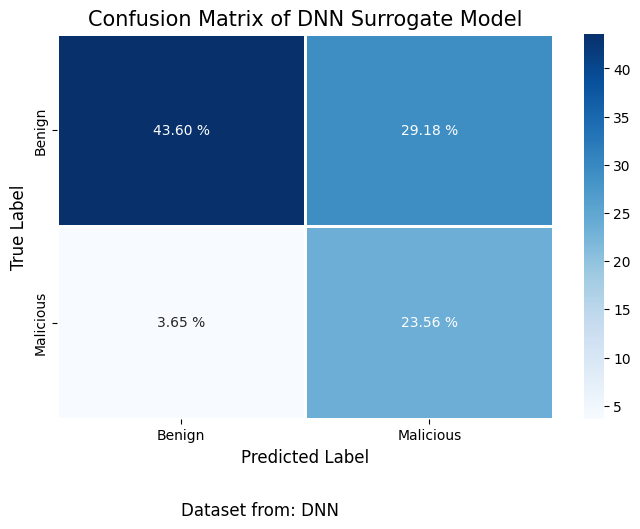

In [34]:
# draw confusion matrix
draw_confusion_matrix(y_test_dnn_predicted, y_pred_list, model, 'DNN', 'DNN')